# Snake Species Identification Challenge

This notebook offers a possible solution to the challenge proposed by crowdAI (https://www.aicrowd.com/challenges/snake-species-identification-challenge). This notebook is intended to finetune a network (ResNet50) to perform snake species classification.


In [1]:
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn as nn
import tensorboardX
import numpy as np
from sklearn.metrics import f1_score
import os
import copy
import fastai

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print("Device: " + str(torch.cuda.get_device_name(0)))

cuda
Device: Tesla K80


### Dataset Preparation

__WARNING: This script assumes that the dataset has been previously splitted. This process is done by the script split_dataset.py, provided in the repository. Before running this script, run split_dataset.py__

Once the dataset is splitted, we proceed to create the training and validation datasets. Since we are dealing with images, we can take advantage of the ImageFolder class that torchvision provides.

#### Datasets & Dataloaders

In [2]:
train_dir = '/home/user/snakes/train/'
validation_dir = '/home/user/snakes/validation/'

# Define training parameters 
size_batch = 32

# Like Albert Pumarola said in class, normalize data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# Define datasets
training_set = torchvision.datasets.ImageFolder(train_dir, transforms.Compose([transforms.RandomSizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize]))
validation_set = torchvision.datasets.ImageFolder(validation_dir, transforms.Compose([transforms.RandomSizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize]))
                                    
# Define dataloaders                               
train_loader = torch.utils.data.DataLoader(training_set, batch_size=size_batch, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=size_batch, shuffle=True, num_workers=2, pin_memory=True)

/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:691: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


Now that datasets and dataloaders are defined, we define the loss function. As we are  tackling a classification problem, we use cross entropy loss. Moreover, we have an unbalanced dataset, so we weight this cross entropy loss according to each class. This weights are computed in the following way:

In [3]:
C = len(training_set.classes)
number_of_training_samples = len(training_set)
print("Number of classes C = " + str(C))
class_balance = torch.empty(C)
i=0
for cl in training_set.classes:
    # We want to penalize more the classes that are less frequent
    class_balance[i] = 1/len(os.listdir(os.path.join(train_dir, cl)))/number_of_training_samples
    i += 1

normalization_factor = class_balance.sum()
class_balance /= normalization_factor
class_balance = class_balance.to(device)

print("Weights provided to the loss:")
print(class_balance)

criterion = nn.CrossEntropyLoss(weight=class_balance)

Number of classes C = 45
Weights provided to the loss:
tensor([0.0280, 0.0333, 0.0167, 0.0148, 0.0022, 0.0369, 0.0429, 0.0391, 0.0072,
        0.0116, 0.0108, 0.0202, 0.0166, 0.0097, 0.0249, 0.0179, 0.0121, 0.0397,
        0.0182, 0.0236, 0.0181, 0.0470, 0.0130, 0.0248, 0.0473, 0.0210, 0.0114,
        0.0349, 0.0233, 0.0261, 0.0078, 0.0054, 0.0217, 0.0293, 0.0420, 0.0045,
        0.0116, 0.0482, 0.0098, 0.0274, 0.0141, 0.0220, 0.0045, 0.0416, 0.0169],
       device='cuda:0')


### Model
Now let us build the model, I am using a ResNet50, which achieves a good accuracy in ImageNet dataset and has a number of parameters relatively low. We also set the layers that will be retrained, setting their requires_grad attribute to True.

In [4]:
model = torchvision.models.resnet50(pretrained=True, progress=True)

num_ftrs = model.fc.in_features
# Change the last layer to classify 45 classes instead of 1000
model.fc = nn.Linear(num_ftrs, C)

# Now let us set which layers we will train in the case of feature extraction
layers_to_train = ['fc.weight','fc.bias']
feature_extract = False

if feature_extract:
    print("Feature Extraction. The layers that will be retrained are:")
    for name,param in model.named_parameters():
        #print(name)
        if(name in layers_to_train):
            param.requires_grad = True
            print("\t",name)
        else: 
            param.requires_grad = False
else:
    print("Finetuning. All layers will be retrained.")
    for name,param in model.named_parameters():        
        param.requires_grad = True

Finetuning. All layers will be retrained.


In [5]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=3e-4)
# Construct a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In order to see if our model can solve the task, which is the same than checking if our model has enough capacity to solve this kind of problem, we try to overfit a single batch. This process also helps when deciding a batch size, since we will check very quickly the maximum batch size that fits in our GPU memory.

In [8]:
def overfit_1_batch(model, dataloaders, criterion, optimizer, device, num_epochs=25):
    # We load 1 batch only
    inputs, labels = next(iter(dataloaders['train']))
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0
                
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # Get model outputs and calculate 
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            # Compute F1-score
            labels_cpu = labels.cpu().numpy()
            predictions_cpu = preds.cpu().numpy()
            F_score = f1_score(labels_cpu, predictions_cpu, average='macro') 
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / size_batch
            epoch_acc = running_corrects.double() / size_batch
            print('{} Loss: {:.4f} Acc: {:.4f} F: {:.3f}'.format(phase, epoch_loss, epoch_acc, F_score))

            
        print()

In [9]:
dataloaders_dict = {'train':train_loader, 'val':val_loader}
model = model.to(device)
overfit_1_batch(model, dataloaders_dict, criterion, optimizer, device,num_epochs=50)

Epoch 0/49
----------
train Loss: 8.0429 Acc: 0.1562 F: 0.083

Epoch 1/49
----------
train Loss: 5.7367 Acc: 0.2188 F: 0.172

Epoch 2/49
----------
train Loss: 4.0705 Acc: 0.3750 F: 0.328

Epoch 3/49
----------
train Loss: 2.9926 Acc: 0.4375 F: 0.434

Epoch 4/49
----------
train Loss: 2.2531 Acc: 0.4688 F: 0.427

Epoch 5/49
----------
train Loss: 1.6225 Acc: 0.6250 F: 0.648

Epoch 6/49
----------
train Loss: 1.0393 Acc: 0.6875 F: 0.665

Epoch 7/49
----------
train Loss: 0.6584 Acc: 0.8750 F: 0.882

Epoch 8/49
----------
train Loss: 0.4369 Acc: 0.9375 F: 0.931

Epoch 9/49
----------
train Loss: 0.2671 Acc: 0.9375 F: 0.931

Epoch 10/49
----------
train Loss: 0.1465 Acc: 1.0000 F: 1.000

Epoch 11/49
----------
train Loss: 0.0799 Acc: 1.0000 F: 1.000

Epoch 12/49
----------
train Loss: 0.0486 Acc: 1.0000 F: 1.000

Epoch 13/49
----------
train Loss: 0.0324 Acc: 1.0000 F: 1.000

Epoch 14/49
----------
train Loss: 0.0240 Acc: 1.0000 F: 1.000

Epoch 15/49
----------
train Loss: 0.0196 Acc: 1.0

### TRAINING


In [10]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25):
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_fscore = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            f_score_list = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate 
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                   
                # statistics
                # Compute F1-score
                labels_cpu = labels.cpu().numpy()
                predictions_cpu = preds.cpu().numpy()
                F_score = f1_score(labels_cpu, predictions_cpu, average='macro') 
                f_score_list.append(F_score)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_f_score = np.average(np.array(f_score_list))
            print('{} Loss: {:.4f} Acc: {:.4f} F: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_f_score))

            # deep copy the model
            
            if phase == 'val' and epoch_f_score > best_fscore:
                best_fscore = epoch_f_score 
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                # Save the model, just in case
                torch.save(model.state_dict(), '/home/user/finetuning/resnet50_snakes_Ep_{}_Acc_{:.3f}_F_{:.3f}.pth'.format(epoch,epoch_acc, epoch_f_score))
                val_acc_history.append(epoch_acc)

        print()
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
dataloaders_dict = {'train':train_loader, 'val':val_loader}
model = model.to(device)

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, device,num_epochs=30)



Epoch 0/0
----------
train Loss: 2.9063 Acc: 0.2690 F: 0.196


Although the code for the training process is shown above, the network has not been trained using jupyter notebook because it makes a bad memory management. In addition, if we run a script from the terminal we can use tmux, which is useful if we have to do some parallel tasks. The learning curves of this model are shown below, the numbers for this curves have been obtained from printings during the training process, this is not a very elegant solution, we could have used tensorboardX, but its configuration with gcloud is difficult and time consuming. Thus, this is a faster way to plot and visualize results.

### RESULTS VISUALIZATION

In [11]:
train_loss = [2.6121, 2.1316,1.9262,1.8072,1.7091,1.6228,1.5566,1.5019,1.4486,1.4124,1.3743,1.3379,1.2909,1.2642,1.2433,1.2069,1.1903,1.1561,1.1385,1.1192,1.0942,1.0683,1.0529,1.0254,1.0105,0.9969,0.9849,0.9563,0.9572,0.9380] 
val_loss = [2.2460,2.0373,1.9521,1.7314,1.7178,1.6337,1.5741,1.6262,1.5200,1.5180,1.4670,1.5097,1.4558,1.3946,1.3635,1.3748,1.3581,1.3776,1.3397,1.3186,1.3167,1.3140,1.3300,1.3118,1.2806,1.3331,1.2982,1.2715,1.3114,1.3013]
train_acc = [0.2586,0.3582,0.4064,0.4357,0.4614,0.4796,0.5026,0.5151,0.5304,0.5424,0.5506,0.5609,0.5718,0.578,0.5862,0.5913,0.5957,0.6045,0.6114,0.6156,0.6221,0.6297,0.6309,0.6395,0.6448,0.6468,0.6491,0.6597,0.6591,0.6632]
val_acc = [0.3371,0.3809,0.4050,0.4461,0.4439,0.4888,0.4986,0.5061,0.5268,0.5185,0.5283,0.5345,0.5241,0.5599,0.5754,0.5203,0.5629,0.5924,0.5898,0.5975,0.5847,0.6076,0.5869,0.5880,0.6081,0.5919,0.5955,0.6206,0.6090,0.6200]
train_F = [0.179,0.256,0.295,0.321,0.343,0.359,0.378,0.388,0.401,0.413,0.421,0.432,0.442,0.448,0.456,0.461,0.464,0.475,0.481,0.486,0.491,0.5,0.502,0.511,0.516,0.519,0.52,0.532,0.533,0.534]
val_F = [0.234,0.274,0.295,0.329,0.324,0.366,0.372,0.381,0.397,0.396,0.396,0.402,0.402,0.431,0.444,0.404,0.436,0.452,0.457,0.458,0.453,0.466,0.456,0.452,0.470,0.453,0.464,0.483,0.472,0.479]

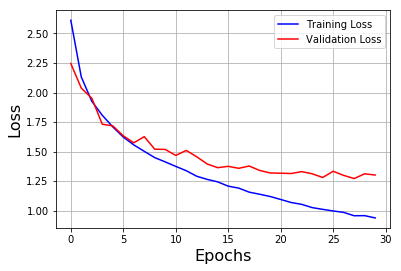

In [12]:
import matplotlib.pyplot as plt
import pylab
pylab.grid()
pylab.xlabel('Epochs', fontsize=16)
pylab.ylabel('Loss', fontsize=16)
t_l, = pylab.plot(range(30), train_loss,'-b', label="Training Loss")
v_l, = pylab.plot(range(30),val_loss, '-r',label="Validation Loss")
pylab.legend()


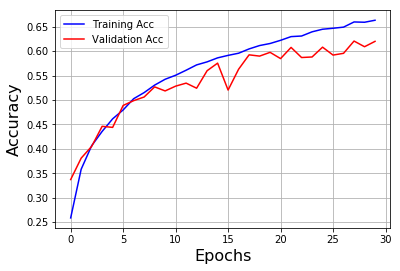

In [13]:
pylab.grid()
pylab.xlabel('Epochs', fontsize=16)
pylab.ylabel('Accuracy', fontsize=16)
t_l, = pylab.plot(range(30), train_acc,'-b', label="Training Acc")
v_l, = pylab.plot(range(30),val_acc, '-r',label="Validation Acc")
pylab.legend()

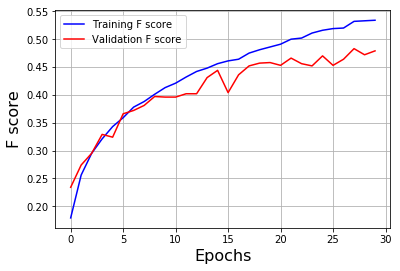

In [14]:
pylab.grid()
pylab.xlabel('Epochs', fontsize=16)
pylab.ylabel('F score', fontsize=16)
t_l, = pylab.plot(range(30), train_F,'-b', label="Training F score")
v_l, = pylab.plot(range(30),val_F, '-r',label="Validation F score")
pylab.legend()

### CONCLUSION

From these charts we can derive that the model we should choose to perform the task is the model from epoch 27, that achieves an accuracy of 62 % and F score 0.483. However, I think that these results can be improved so I will try applying dropout in the following notebook: Snake Classification-Dropout.